In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import polars as pl

#sns.reset_orig()

# # Michael's matplotlib defaults
# # set font to Times New Roman
# LATEX = False
# if LATEX:
#     mpl.rcParams['text.usetex'] = True
#     mpl.rcParams["font.family"] = "serif"
#     mpl.rcParams["font.serif"] = "Times"
# else:
#     mpl.rcParams['text.usetex'] = False
#     mpl.rcParams["font.family"] = "Times New Roman"
#     mpl.rcParams["mathtext.fontset"] = "stix"
    
# plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False


colors = ['#a1c9f4', '#8de5a1', '#ff9f9b', '#d0bbff', '#fffea3', '#b9f2f0']
cmap = mpl.colors.ListedColormap(colors)
bar1 = {'color': colors[0], 'edgecolor': 'k'}
bar2 = {'color': colors[1], 'edgecolor': 'k'}
bar3 = {'color': colors[2], 'edgecolor': 'k'}

In [2]:
def get_query_id(filename):
    return filename.split('-')[0].upper()


/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_17596/1059697988.py:4: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(


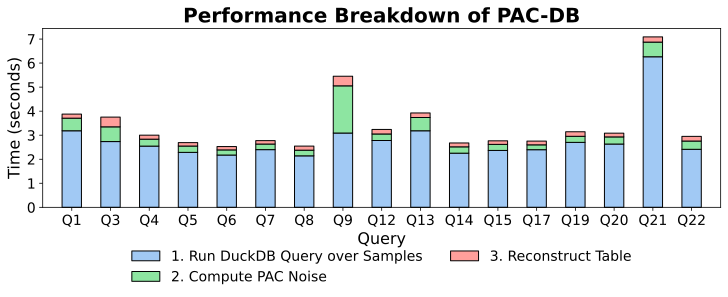

In [3]:
# Load JSON file into Polars DataFrame

df = pl.read_json("../benchmarks/all.json")
df = df.with_columns(
    pl.col("query").map_elements(get_query_id).alias("query"))

# Get the 'query' column as list of labels
queries = df["query"].to_list()

# Get the step columns
step_columns = [col for col in df.columns if col.startswith("step")]

# Get values for each step column
step_values = [df[col].to_list() for col in step_columns]

# Bar positions
x = range(len(queries))

# Create the stacked bar plot
plt.figure(figsize=(10, 4), constrained_layout=True)
bottom = [0] * len(queries)
bar_width = 0.5
step_columns = ["1. Run DuckDB Query over Samples", "2. Compute PAC Noise", "3. Reconstruct Table"]
for values, label, style in zip(step_values, step_columns, [bar1, bar2, bar3]):
    plt.bar(x, values, bottom=bottom, label=label, width=bar_width, **style)
    bottom = [b + v for b, v in zip(bottom, values)]

# Final plot formatting
plt.xlim([x[0] - (1.5*bar_width), x[-1] + (1.5*bar_width)])
plt.xticks(x, queries, ha='center', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time (seconds)', fontsize=16)
plt.xlabel('Query', fontsize=16)
plt.title("Performance Breakdown of PAC-DB", fontsize=20)
# plt.subplots_adjust(bottom=0.6)

plt.legend(loc='lower center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, -0.5))
# plt.tight_layout()
plt.savefig("../figs/benchmark_pac_step_by_step.png", dpi=300, bbox_inches='tight')


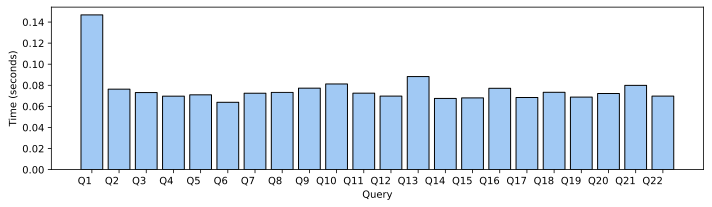

In [4]:
unnoised = pl.read_json("../unnoised/times.json")
# Get the 'query' column as list of labels
queries_unnoised = unnoised["query"].to_list()
# Just has a 'total' column for times
unnoised_total = unnoised["total"].to_list()
x = range(len(queries_unnoised))
# Create the bar plot for unnoised times
plt.figure(figsize=(10, 3))
plt.bar(x, unnoised_total, color=colors[0], edgecolor='k')
plt.xticks(x, queries_unnoised, ha='right')
plt.xlabel('Query')
plt.ylabel('Time (seconds)')
plt.tight_layout()
plt.show()

In [5]:
# use polars to compute the speedup
df2 = df.with_columns(
    (pl.col("step1") + pl.col("step2") + pl.col("step3")).alias("noised_total")
).drop("step1", "step2", "step3")
# unnoised2 = unnoised.filter(pl.col("query").is_in(df["query"].implode()))
unnoised2 = unnoised.with_columns(
    pl.col("total").alias("unnoised_total")
).drop("total")
df2 = df2.join(unnoised2, on="query", how="right")
df2

mi,noised_total,query,unnoised_total
f64,f64,str,f64
0.125,3.877524,"""Q1""",0.146787
null,null,"""Q2""",0.07631
0.125,3.754201,"""Q3""",0.073106
0.125,3.001589,"""Q4""",0.069695
0.125,2.69158,"""Q5""",0.07094
…,…,…,…
null,null,"""Q18""",0.073351
0.125,3.143472,"""Q19""",0.068805
0.125,3.08402,"""Q20""",0.072192


In [6]:
unnoised2 = unnoised.with_columns(
    pl.col("total").alias("unnoised_total")
).drop("total")

unnoised2

query,unnoised_total
str,f64
"""Q1""",0.146787
"""Q2""",0.07631
"""Q3""",0.073106
"""Q4""",0.069695
"""Q5""",0.07094
…,…
"""Q18""",0.073351
"""Q19""",0.068805
"""Q20""",0.072192


In [7]:
df2 = df2.with_columns([
    # First handle the Q2, Q11, Q16 case for noised_total
    pl.when(pl.col("query").is_in(["Q2", "Q11", "Q16"]))
    .then(pl.col("unnoised_total"))
    .otherwise(pl.col("noised_total"))
    .alias("noised_total")
]).with_columns([
    # Then handle Q10, Q18 case for both columns
    pl.when(pl.col("query").is_in(["Q10", "Q18"]))
    .then(0)
    .otherwise(pl.col("noised_total"))
    .alias("noised_total"),
])

In [8]:
df2

mi,noised_total,query,unnoised_total
f64,f64,str,f64
0.125,3.877524,"""Q1""",0.146787
null,0.07631,"""Q2""",0.07631
0.125,3.754201,"""Q3""",0.073106
0.125,3.001589,"""Q4""",0.069695
0.125,2.69158,"""Q5""",0.07094
…,…,…,…
null,0.0,"""Q18""",0.073351
0.125,3.143472,"""Q19""",0.068805
0.125,3.08402,"""Q20""",0.072192


In [9]:
# compute percentage
df2 = df2.with_columns(
    (pl.col("noised_total") / pl.col("unnoised_total")).alias("relative_speed")
)
df2

mi,noised_total,query,unnoised_total,relative_speed
f64,f64,str,f64,f64
0.125,3.877524,"""Q1""",0.146787,26.415961
null,0.07631,"""Q2""",0.07631,1.0
0.125,3.754201,"""Q3""",0.073106,51.352975
0.125,3.001589,"""Q4""",0.069695,43.067491
0.125,2.69158,"""Q5""",0.07094,37.941632
…,…,…,…,…
null,0.0,"""Q18""",0.073351,0.0
0.125,3.143472,"""Q19""",0.068805,45.686851
0.125,3.08402,"""Q20""",0.072192,42.719718


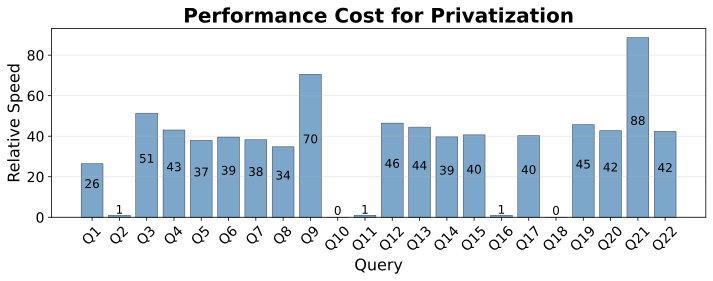

In [11]:
# Alternative with more customization:
plt.figure(figsize=(10, 4))
bars = plt.bar(df2["query"], df2["relative_speed"], 
               color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height/2.,
             f'{int(height)}', ha='center', va='bottom', fontsize=12)

plt.xlabel("Query", fontsize=16)
plt.ylabel("Relative Speed", fontsize=16)
plt.title("Performance Cost for Privatization", fontsize=20, fontweight='bold')
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("../figs/pac_performance_costs.png",  dpi=300, bbox_inches='tight')
